Import libraries

In [1]:
import pandas as pd
from os import listdir
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn import dummy
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

Read data

In [2]:
folder = '/content/drive/MyDrive/Colab Notebooks/movie_lens/'

ratings = pd.read_csv(
    folder+ '/ratings.dat',
    sep = "::",
    names = ['userId', 'movieId', 'rating', 'timestamp']
)

movies = pd.read_csv(
    folder+  '/movies.dat',
    sep = "::",
    names = ['movieId', 'title', 'genres'],
    encoding='latin-1',
    engine='python',
)

<ipython-input-2-b32693dca89d>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


<h1>EDA and feature engineering</h1>

Ratings

In [5]:
ratings.shape

(1000209, 4)

50% of the movies have more than 123 reviews whereas the maximum reviews for a movie are ~3k

In [6]:
# Takes a minute to run

ratings.groupby("movieId").agg({"userId":"nunique"}).reset_index().userId.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: userId, dtype: float64

Each user has at least reviewed 20 movies with a maximum of  ~2314 movies reviewed by a user

In [7]:
ratings.groupby("userId").agg({"movieId":"nunique"}).reset_index().movieId.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movieId, dtype: float64

Movies dataset

In [8]:
# Extract year in movies dataset

movies["year"] = movies.title.str.extract("\((\d{4})\)", expand=True).astype(str)
movies['title'] = movies.title.str[:-7]
movies['title'] = movies.title.str.lower()
movies = movies.join(movies['genres'].str.get_dummies())
movies.drop('genres', inplace=True, axis=1)
movies.rename(columns={'(no genres listed)':'No genre'}, inplace=True)

movies.head()

,movieId,title,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,toy story,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,jumanji,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,grumpier old men,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,waiting to exhale,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,father of the bride part ii,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Num of movies released per year -> We have movies as old as from 1891.

<Axes: title={'center': 'Num of movies relased'}, xlabel='year'>

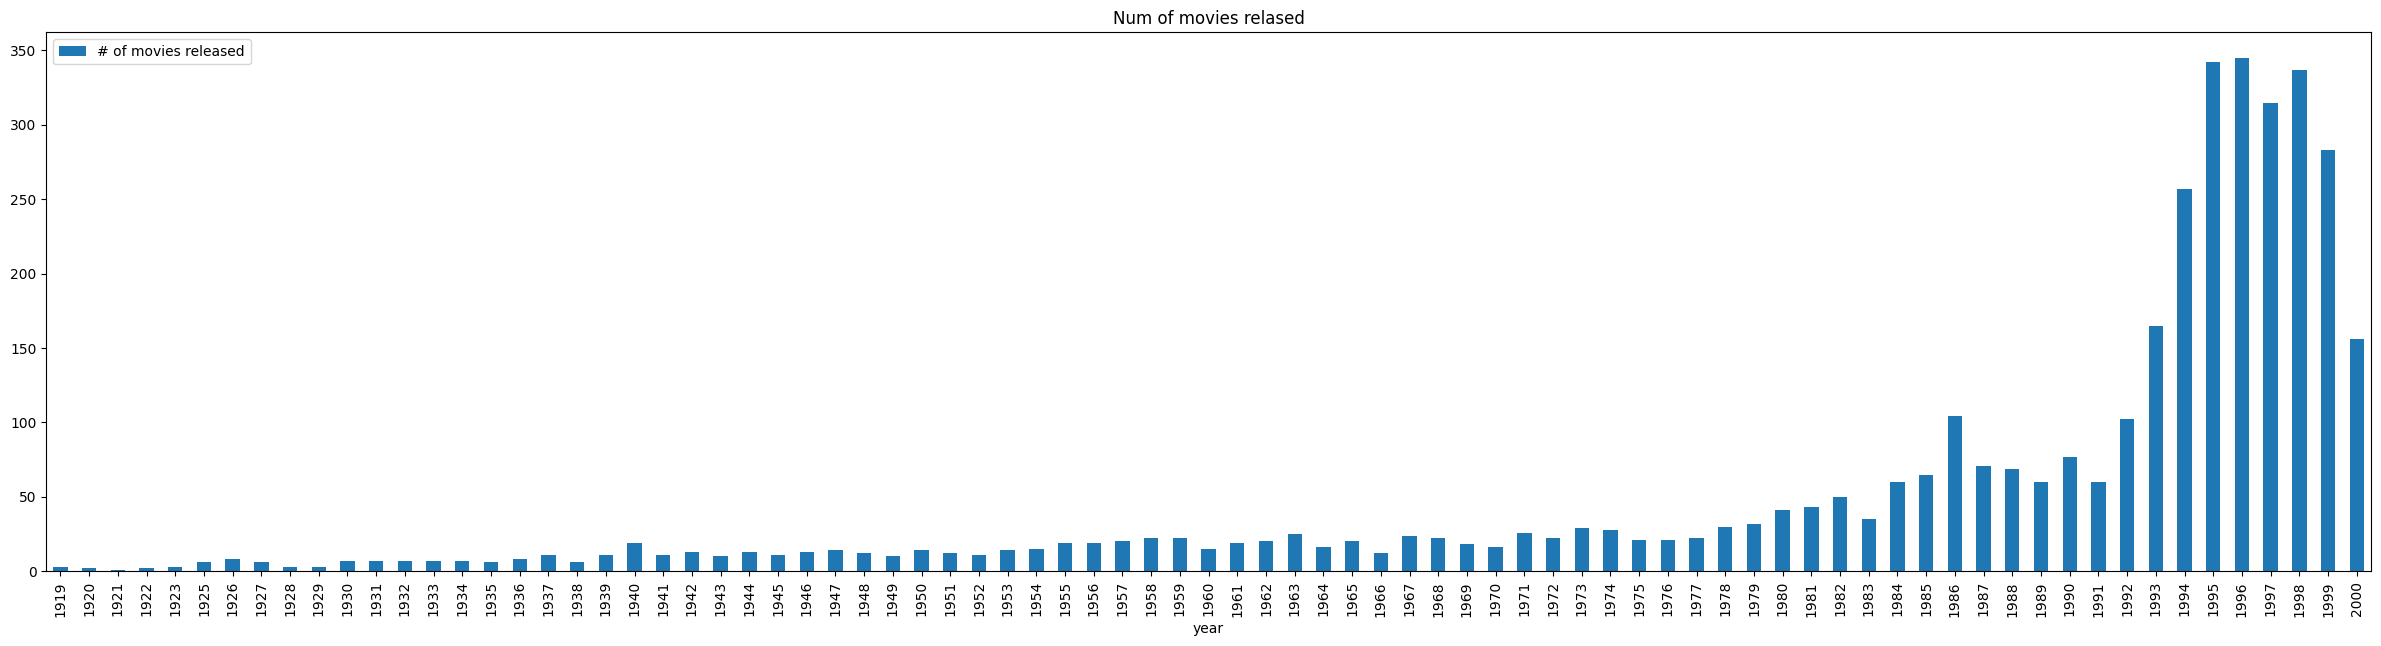

In [9]:
movies[["year", "title"]]\
        .groupby(['year'])['title'].count().reset_index()\
        .rename(columns={'title':'# of movies released'})\
        .plot.bar(x='year', y='# of movies released', figsize=(30,7), title='Num of movies relased')


Building the Deep learning model

ML problem statement - Build a model to predict

# Recommend movies for a user

1. Dummy classifier
2. Matrix Factorization
3. Deep learning based approach


In [10]:
#reduce the total data size
df_final = ratings[["userId", "movieId", "rating"]].merge(movies[[c for c in movies.columns if c not in ['title', 'year']]], on='movieId', how='left')

In [11]:
df_final.head()

,userId,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,661,3,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,914,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
train, test = train_test_split(df_final, test_size=0.1, shuffle=True)

Dummy classifier

In [13]:

dummy_model = dummy.DummyClassifier(strategy='prior')
dummy_model.fit(train[[c for c in train.columns if c != 'rating']], train.rating)



DummyClassifier()

In [14]:
print(mean_absolute_error(test.rating, dummy_model.predict(test[[c for c in train.columns if c != 'rating']])))

0.8703472270823127


#Matrix Factorization apporach

Cons:
1. It can suffer from overfitting and underfitting
2. Cannot recommend for users/movies outside the dataset

In [15]:
df_pivot = train.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

In [16]:
df_pivot.shape

(6040, 3691)

In [17]:
# convert to matrix
R = df_pivot.values

# de mean the data - so that mean is 0
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)


In [18]:
# Perform SVDS
U, sigma, Vt = svds(R_demeaned, k = 50)

In [19]:
sigma = np.diag(sigma)

In [20]:
#predictions for all users
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_pivot.columns)
preds_df.head()


movieId      1         2         3         4         5         6         7     \
0        4.401979  0.191164 -0.095259 -0.017744  0.045833 -0.178047 -0.095493   
1        0.213321  0.099350  0.230360 -0.015430  0.039094  1.108348  0.070793   
2        1.225117  0.547625  0.105832 -0.034145 -0.036809 -0.083058 -0.165609   
3        0.519096 -0.092774  0.014492  0.079041  0.000582  0.237241  0.001339   
4        1.683801 -0.001043 -0.142019  0.148549 -0.029056  1.375926 -0.161780   

movieId      8         9         10        11        12        13        14    \
0        0.116570 -0.030916 -0.257649  0.296286 -0.093371  0.265216  0.045998   
1        0.078787  0.133828  1.474587  0.876348  0.034638 -0.025875 -0.008941   
2        0.106523  0.033733  0.572775 -0.110810  0.055608  0.064047 -0.068317   
3        0.002086  0.046524 -0.157969 -0.234156  0.015827  0.007779  0.084952   
4       -0.004945 -0.062970  0.373866 -0.350132 -0.001659 -0.068584  0.323464   

movieId      15        16        17        18        19        20        21    \
0       -0.036130 -0.092721  0.293482 -0.005013 -0.071139 -0.037376 -0.176246   
1        0.003064  0.462889  0.992744 -0.092341 -0.145632  0.210400  2.375440   
2        0.072416  0.048637 -0.173159  0.113711  0.035901  0.090444  0.374311   
3       -0.061558 -0.217747  0.047882 -0.049312  0.043529  0.050244  0.387252   
4        0.023644  1.060479  1.382688  0.286678  0.069618 -0.082329  1.782419   

movieId      22        23        24        25        26        27        28    \
0        0.082423  0.010989  0.265241 -0.128025 -0.046704  0.030367 -0.089693   
1       -0.052356 -0.026946  0.144767  1.016993  0.203579 -0.040381  0.049477   
2        0.069443  0.069127 -0.018541  0.035121  0.008219 -0.008389 -0.163095   
3       -0.069273 -0.042172 -0.071087  0.256030 -0.020286  0.027691  0.042940   
4        0.090096 -0.038906  0.419285  1.497322  0.162720 -0.064097  0.430172   

movieId      29        30        31        32        33        34        35    \
0       -0.005606 -0.000977 -0.002283  0.328069 -0.001036  2.252561 -0.017146   
1       -0.200727  0.086501 -0.048866  0.129740 -0.001436  0.332716  0.035202   
2        0.007488 -0.054739  0.015187 -0.253219 -0.012672  0.426612 -0.091558   
3       -0.035606  0.007597 -0.006526  0.201038 -0.021586 -0.342240  0.008368   
4        1.079130  0.313068 -0.023025  1.966952  0.016882  2.796395  0.316941   

movieId      36        37        38        39        40        41        42    \
0        0.761661  0.015228  0.014755 -0.094974 -0.004201  0.021564  0.102772   
1        1.272746 -0.015325 -0.022723 -0.059739  0.128184  0.018723  0.162003   
2        0.210838 -0.018274 -0.027919  0.239578  0.004315 -0.191782  0.054995   
3        0.110873 -0.029961  0.024968 -0.170932 -0.031416 -0.128610  0.037929   
4        1.475044  0.046475  0.003083  1.220669  0.108096  0.757655  0.275756   

movieId      43        44        45        46        47        48        49    \
0       -0.022110 -0.025841 -0.147057 -0.052847  0.187870  0.893898 -0.029691   
1        0.019435  0.320340 -0.179662 -0.021393  0.011621 -0.194803  0.011151   
2       -0.109141  0.116010  0.001243 -0.057549 -0.042036 -0.001503  0.002422   
3       -0.031072  0.010282  0.138103 -0.000714 -0.238711 -0.003182  0.005384   
4        0.575687 -0.049497  1.222128  0.014072  1.827879 -0.082461  0.146266   

movieId      50        52        53        54        55        56        57    \
0        0.321754 -0.219213  0.005593  0.045876  0.012432  0.000768 -0.010017   
1       -0.403521  0.158725 -0.008321 -0.031424  0.033546  0.003358 -0.039071   
2       -0.091653  0.027502  0.003922 -0.015500 -0.020755  0.009297 -0.053239   
3       -0.181191 -0.023939 -0.017677 -0.000427  0.033162 -0.010850  0.034662   
4        3.862749  0.893020  0.070983  0.022576  0.157370  0.021809  0.261160   

movieId      58        59        60        61        62        63        64    \
0        0.001476  0.01

In [21]:
pred_df_melt = pd.melt(preds_df.reset_index(), id_vars = 'index').rename(columns={'index':'userId', 'value':'rating_pred'})

pred_df_melt = pred_df_melt.merge(test[['movieId', 'userId', 'rating']], on=['movieId', 'userId'], how='inner')

pred_df_melt['rating_pred'] = np.where(pred_df_melt['rating_pred'] < 0, 0, pred_df_melt['rating_pred'])

pred_df_melt['rating_pred'] = np.where(pred_df_melt['rating_pred'] > 5, 5, pred_df_melt['rating_pred'])

pred_df_melt.head()

,userId,movieId,rating_pred,rating
0,76,1,0.000000,5
1,96,1,0.896997,4
2,147,1,2.563652,4
3,202,1,0.000000,4
4,273,1,0.542377,5


The primary reason for bad rmse is because:
1. Matrix factorization can suffer from overfitting and underfitting
2. Cannot recommend for users/movies outside the dataset. (the split of test vs train causes the issue)

In [22]:
print(mean_absolute_error(pred_df_melt.rating_pred, pred_df_melt.rating))

3.1024788685956364


In [23]:
pred_df_melt.rating_pred.describe()

count    99968.000000
mean         0.515267
std          0.910866
min          0.000000
25%          0.000000
50%          0.105745
75%          0.569313
max          5.000000
Name: rating_pred, dtype: float64

Deep learning based approach

In [24]:
df_final.head()

,userId,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,661,3,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,914,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
n_users = train.userId.nunique()

tf.keras.backend.clear_session()

# Now, the deep learning classifier

# First, we take the genre and vectorize it.
# The embedding layer is normally used for sequences
# The dropout layer is also important in preventing overfitting

genre_input = tf.keras.layers.Input(shape=[18,])
genre_vec = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(18,2)(genre_input))
genre_vec = tf.keras.layers.Dropout(0.5)(genre_vec)


# Same thing for the users
user_input = tf.keras.layers.Input(shape=[1,])
user_vec = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(n_users + 1, 32)(user_input))
user_vec = tf.keras.layers.Dropout(0.5)(user_vec)

# Next, we join them all together and put them
# through a pretty standard deep learning architecture
input_vecs = tf.concat([genre_vec, user_vec], axis = 1)
nn = tf.keras.layers.Dropout(0.5)(tf.keras.layers.Dense(128, activation='relu')(input_vecs))
nn = tf.keras.layers.BatchNormalization()(nn)
nn = tf.keras.layers.Dropout(0.5)(tf.keras.layers.Dense(128, activation='relu')(nn))
nn = tf.keras.layers.BatchNormalization()(nn)
nn = tf.keras.layers.Dense(128, activation='relu')(nn)

# Finally, we pull out the result!
result = tf.keras.layers.Dense(5, activation='softmax')(nn)

# And make a model from it that we can actually run.
model = tf.keras.Model([genre_input, user_input], result)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 18, 2)        36          ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        193312      ['input_2[0][0]']                
                                                                                              

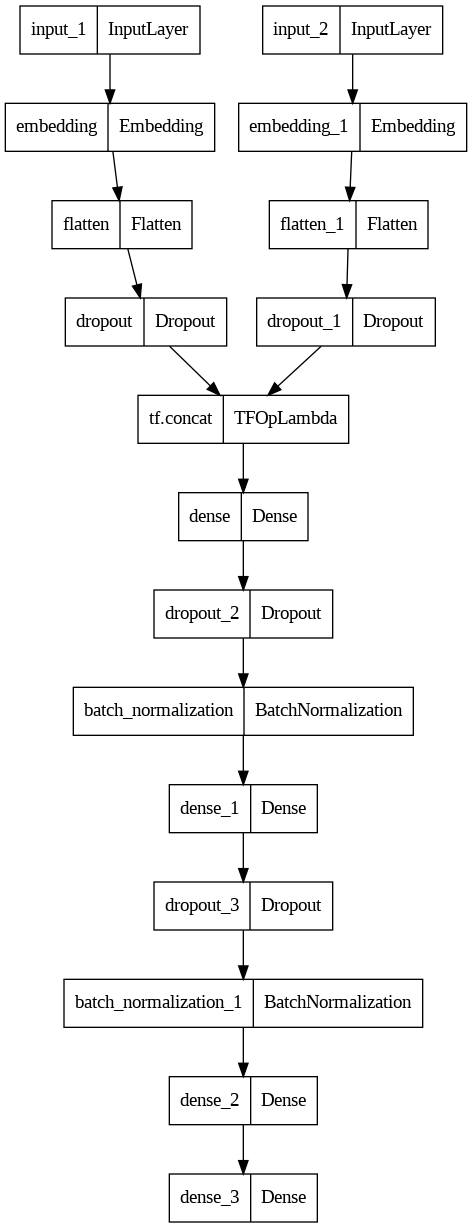

In [27]:
tf.keras.utils.plot_model(model)

In [28]:
train_rating_correction = train.copy()

train_rating_correction['rating'] = train_rating_correction['rating'] - 1

train_nn, val_nn = train_test_split(train_rating_correction, test_size=0.1, shuffle=True)

In [29]:
cols_genre = [c for c in train_nn.columns if c not in ('userId', 'movieId', 'rating')]

In [30]:
history = model.fit([train_nn[cols_genre], train_nn['userId']], train_nn['rating'], epochs=20,
                         validation_data=([val_nn[cols_genre], val_nn['userId']], val_nn['rating']))


Epoch 1/20
25318/25318 [==============================] - 192s 7ms/step - loss: 1.4007 - accuracy: 0.3672 - val_loss: 1.3506 - val_accuracy: 0.3955
Epoch 2/20
25318/25318 [==============================] - 183s 7ms/step - loss: 1.3632 - accuracy: 0.3895 - val_loss: 1.3435 - val_accuracy: 0.3963
Epoch 3/20
25318/25318 [==============================] - 186s 7ms/step - loss: 1.3569 - accuracy: 0.3941 - val_loss: 1.3423 - val_accuracy: 0.3984
Epoch 4/20
25318/25318 [==============================] - 190s 7ms/step - loss: 1.3535 - accuracy: 0.3954 - val_loss: 1.3433 - val_accuracy: 0.3957
Epoch 5/20
25318/25318 [==============================] - 187s 7ms/step - loss: 1.3519 - accuracy: 0.3964 - val_loss: 1.3416 - val_accuracy: 0.3976
Epoch 6/20
25318/25318 [==============================] - 190s 7ms/step - loss: 1.3504 - accuracy: 0.3966 - val_loss: 1.3403 - val_accuracy: 0.3999
Epoch 7/20
25318/25318 [==============================] - 183s 7ms/step - loss: 1.3493 - accuracy: 0.3975 - val_

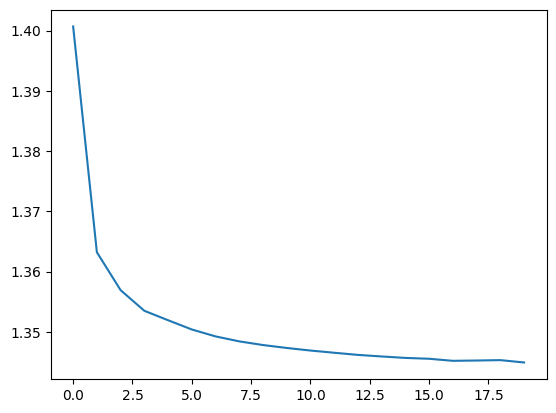

In [31]:
plt.plot(history.history['loss'])



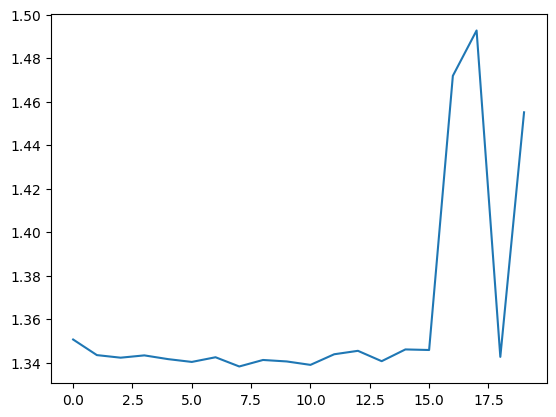

In [32]:
plt.plot(history.history['val_loss'])

In [33]:
mean_absolute_error(test['rating'], np.argmax(model.predict([test[cols_genre], test['userId']]), 1)+1)

3126/3126 [==============================] - 8s 3ms/step


0.7938732866098119